<a href="https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/5_2_a_simple_encoding_with_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Just installing some of the necessary libraries to get the data and process the data

In [0]:
!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2
!pip install -U seaborn
!pip install nilearn

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Requirement already up-to-date: pymvpa2 in /usr/local/lib/python2.7/dist-packages (2.6.5)
Requirement already up-to-date: seaborn in /usr/local/lib/python2.7/dist-packages (0.9.0)


# Copying the word list and the word2vec model from Google Drive to Colab, so it will take some time.

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


word_list_id = 'https://drive.google.com/open?id=18nfVy-o0GWX-QKEWrKK0EKLLAltpFy4U'.split('id=')[-1]
word2vec_model_id = 'https://drive.google.com/open?id=1Dj9aTqHbuknWZC9kQJabqH3NqGXe_PT4'.split('id=')[-1]

word_list = drive.CreateFile({'id':word_list_id})
word2vec_model_ = drive.CreateFile({'id':word2vec_model_id})

word_list.GetContentFile('{}'.format('word.npy'))
word2vec_model_.GetContentFile('{}'.format('glove-sbwc.i25.vec'))

In [0]:
roi_id = 'https://drive.google.com/open?id=10cAoPizl69QR2RekIKpkdrv9J4_Emcq-'.split('id=')[-1]
roi = drive.CreateFile({'id':roi_id})
roi.GetContentFile('{}'.format('roi.pkl'))

In [0]:
fmri_data_id = 'https://drive.google.com/open?id=1azfJELUXpALhuqk9QjkgQxscjngt8FIK'.split('id=')[-1]
mask_id = 'https://drive.google.com/open?id=1chMTgitz5Qb9rEjGN5ZOGLJIMxbnwC8j'.split('id=')[-1]
struc_id = 'https://drive.google.com/open?id=1Ctlw4_Qw43K3KEvFDA3NhOaW-nAOBWAd'.split('id=')[-1]
functional_id = 'https://drive.google.com/open?id=1dhIqqdovNFsaVVZKJTWEOSqRBBfMlkHR'.split('id=')[-1]

fmri_data = drive.CreateFile({'id':fmri_data_id})
mask = drive.CreateFile({'id':mask_id})
struc = drive.CreateFile({'id':struc_id})
functional = drive.CreateFile({'id':functional_id})

fmri_data.GetContentFile('{}'.format('filtered_func_data.nii.gz'))
mask.GetContentFile('{}'.format('roi_4_bin.nii.gz'))
struc.GetContentFile('{}'.format('output.nii'))
functional.GetContentFile('{}'.format('example_func.nii.gz'))

# The python libraries we will need to import

1. numpy: numerical python
2. pandas: table
3. tqdm: progress bar
4. **gensim**: need for loading word2vec models
12. seaborn (better in 0.9.0 version): pretty plotting
13. pickle: to load the dataset (PYMVPA format) that is stored in a pickle dump file
14. Ridge regression, can be replaced by linear SVM regressor nested with L1 regularizer
8. mean_group_sample: Pymvpa averaging function
9. seaborn: plotting
10. plot_stat_map, plot_glass_brain: nilearn plotting function, MRI visualization
11. threshold_img: not important

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from gensim.models.keyedvectors import KeyedVectors # for loading word2vec models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from mvpa2.mappers.fx import mean_group_sample 
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')
import pickle
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import threshold_img


In [0]:
# candidate model
Glove_from_SBWC = 'glove-sbwc.i25.vec'
# load the stimuli table
words = np.load('word.npy')
print('loading Glove model, and it is going to take some time...')
model_glove = KeyedVectors.load_word2vec_format(Glove_from_SBWC)

loading Glove model, and it is going to take some time...


# Load the BOLD signal data

## Some description of the experiment:

1. there were 2 conditions: read and reenact
2. In the read condition, subjects were asked to read the words presented on the screen repeatedly
3. In the reenact condition, subjects were asked to think about "features" that are associated with the words presented
4. There were 36 unique words, and they were presented once at each block of scanning. 
5. There were 4 blocks of scanning


In [0]:
ds = pickle.load(open('roi.pkl','rb'))

# Select a condition

In [0]:
condition = 'read'

In [0]:
dataset = ds[ds.sa.context == condition]

# My helper functions for cross validation partitioning. I don't like to average the training data but to average the testing data. Since we must partitioning the data according to trials and blocks, we must also acknowledge that multiple volumes correspond to the same trial of a given block. These helper functions are for these purpose.

In [0]:
def get_blocks(dataset__,label_map,key_type='labels'):
    """
    # use ids, chunks,and labels to make unique blocks of the pre-average dataset, because I don't want to 
    # average the dataset until I actually want to, but at the same time, I want to balance the data for 
    # both the training and test set.
    """
    ids                     = dataset__.sa.id.astype(int)
    chunks                  = dataset__.sa.chunks
    words                   = dataset__.sa.words
    if key_type == 'labels':
        try: # in metasema
            labels              = np.array([label_map[item] for item in dataset__.sa.targets])[:,-1]
        except:# not in metasema
            labels              = np.array([label_map[item] for item in dataset__.sa.targets])
        
    elif key_type == 'words':
        labels              = np.array([label_map[item] for item in dataset__.sa.words])
    sample_indecies         = np.arange(len(labels))
    blocks                  = [np.array([ids[ids             == target],
                                         chunks[ids          == target],
                                         words[ids           == target],
                                         labels[ids          == target],
                                         sample_indecies[ids == target]
                                         ]) for target in np.unique(ids)]
    block_labels            = np.array([np.unique(ll[-2]) for ll in blocks]).ravel()
    return blocks,block_labels
def customized_partition(dataset__,label_map):
    unique_words = np.unique(dataset__.sa.words)
    unique_chunks = np.unique(dataset__.sa.chunks)
    try: # in metasema
        labels              = np.array([label_map[item] for item in dataset__.sa.targets])[:,-1]
    except:# not in metasema
        labels              = np.array([label_map[item] for item in dataset__.sa.targets])
    words = dataset__.sa.words
    chunks = dataset__.sa.chunks
    blocks,block_labels = get_blocks(dataset__,label_map,key_type='labels')
    sample_indecies         = np.arange(len(labels))
    test = []
    check = []
    for n in range(int(1e5)):
        random_chunk = np.random.choice(unique_chunks,size=1,replace=False)[0]
        working_words = words[chunks == random_chunk]
        working_block = [block for block in blocks if (int(np.unique(block[1])[0]) == random_chunk)]
        random_word = np.random.choice(working_words,size=1,replace=False)[0]
        if random_word not in check:
            for block in working_block:
                if (np.unique(block[2])[0] == random_word) and (random_word not in check):
                    test.append(block[-1].astype(int))
                    check.append(block[2][0])
#                    print(test,check)
                if len(check) == len(unique_words):
                    break
            if len(check) == len(unique_words):
                break
        if len(check) == len(unique_words):
            break
    test = np.concatenate(test,0).flatten()
    train = np.array([idx for idx in sample_indecies if (idx not in test)])
    return train,test

# Define something before the encoding model

In [0]:
label_map               = dict(animal  =[0,1],
                               tool    =[1,0])
n_splits = 100
labels                  = np.array([label_map[item] for item in dataset.targets])
alpha = 1e2

In [0]:
used_test = []
fold = -1
scores = []
for _ in tqdm(range(10000)):
    #print('paritioning ...')
    idx_train,idx_test = customized_partition(dataset,label_map,)
    if any([np.sum(idx_test) == np.sum(item) for item in used_test]):
        pass
    else:
        fold += 1
        used_test.append(idx_test)
        #print('done')
        
        clf = Ridge(alpha = alpha,         # L1 penalty, higher means more weights are constrained to zero
                    normalize = False,         # normalize the batch features
                    max_iter = -1,            # train until it converts
                    random_state = 12345          # random seeding
                    )
        tr = dataset[idx_train]
        te = dataset[idx_test].get_mapped(mean_group_sample(['chunks', 'id'],order = 'occurrence'))
        
        ########################### This is the part we line up the stimulus feature (word2vec) to the BOLD signals at each trial###########################################
        stimuli = np.array([model_glove[word.lower()] for word in tr.sa.words])
        fmri_data = tr.samples.astype('float32')
        ####################################################################################################################################################################
        
        clf.fit(stimuli,fmri_data)
        preds = clf.predict(np.array([model_glove[word.lower()] for word in te.sa.words]))
        scores.append(r2_score(te.samples.astype('float32'),
                               preds,
                               multioutput = 'raw_values'))
    if (len(used_test) == n_splits) or (fold == n_splits):
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

 * Please note: warnings are printed only once, but underlying problem might occur many times *


  1%|          | 99/10000 [00:53<1:23:17,  1.98it/s]

In [0]:
scores = np.array(scores)

In [0]:
print('mean variance = ',np.mean(scores[scores>0]),'positive values = ',np.sum(scores.mean(0)>0))

('mean variance = ', 0.05685189038658059, 'positive values = ', 2)


# Load the structure scan and function scan for visualization

In [0]:
fmri_dir = 'filtered_func_data.nii.gz'
mask_dir = 'roi_4_bin.nii.gz'
struc_dir = 'output.nii'
functional_dir = 'example_func.nii.gz'

In [0]:
from nilearn.input_data import MultiNiftiMasker

masker = MultiNiftiMasker(mask_img=mask_dir, detrend=True,
                          standardize=True)
masker.fit()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


MultiNiftiMasker(detrend=True, dtype=None, high_pass=None, low_pass=None,
         mask_args=None, mask_img='roi_4_bin.nii.gz',
         mask_strategy='background', memory=Memory(location=None),
         memory_level=0, n_jobs=1, smoothing_fwhm=None, standardize=True,
         t_r=None, target_affine=None, target_shape=None, verbose=0)

In [0]:
cut_score = np.mean(scores, axis=0)
cut_score[cut_score < 0] = 0

# bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(cut_score)

thresholded_score_map_img = threshold_img(score_map_img, threshold=1e-6)

/usr/local/lib/python2.7/dist-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-

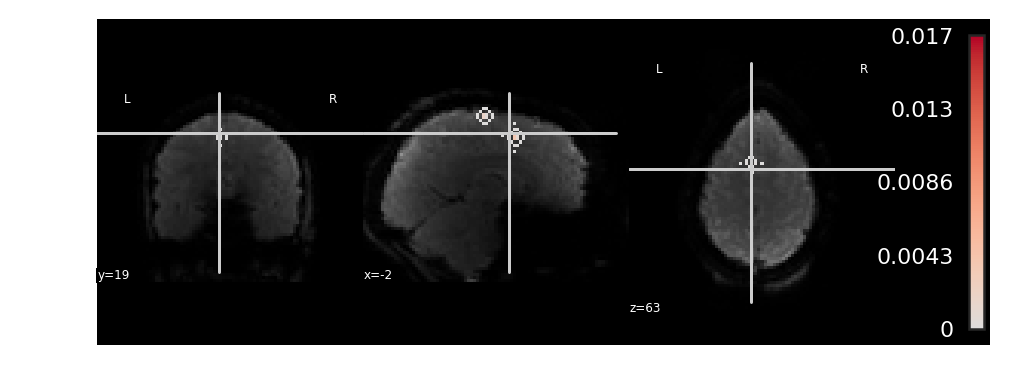

In [0]:
fig,ax = plt.subplots(figsize=(16,6))
plot_stat_map(score_map_img, 
              bg_img=functional_dir,
              figure=fig,
              axes=ax,
              black_bg=True,
              colorbar=True,
              cmap='coolwarm',
              threshold='auto',)

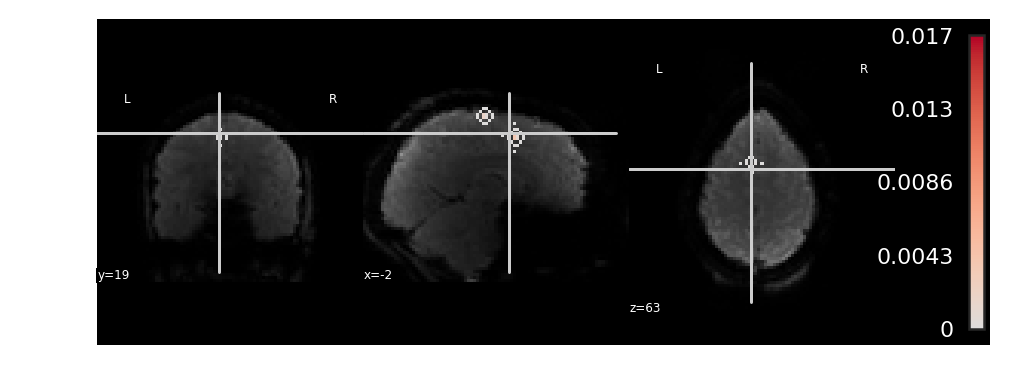

In [0]:
fig,ax = plt.subplots(figsize=(16,6))
plot_stat_map(thresholded_score_map_img, 
              bg_img=functional_dir,
              figure=fig,
              axes=ax,
              black_bg=True,
              colorbar=True,
              cmap='coolwarm',
              threshold='auto',)